# INF2178 Midterm - Group 15
Xinxuan Lin, Peggy Pu

Note: The plots may not able to display on Github, but can be seen on google colab platform.

https://colab.research.google.com/drive/15CehIs6GpmbLmq2oeijhz2ZhwyfeBHmb?usp=sharing

In [ ]:
# load the packages
import pandas as pd
import numpy as np

import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from statsmodels.graphics.factorplots import interaction_plot
import matplotlib.pyplot as plt

from scipy import stats
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.formula.api import ols

from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.stats.multicomp as mc

# Data Cleaning 

In [ ]:
# import dataset
arr = pd.read_csv('/content/sample_data/Arrests_and_Strip_Searches_(RBDC-ARR-TBL-001).csv')

In [ ]:
# extract the needed attributes: PersonID, StripSearch, Perceived_Race, Sex
df_eda = arr.loc[:,["PersonID", "Perceived_Race", "Sex", 
                    "Age_group__at_arrest_",'Youth_at_arrest__under_18_years',
                   'Actions_at_arrest___Concealed_i','Actions_at_arrest___Combative__',
                   'Actions_at_arrest___Resisted__d','Actions_at_arrest___Mental_inst',
                   'Actions_at_arrest___Assaulted_o',"StripSearch"]]

# Replace the na value in Perceived Race to "Unknown or Legacy"
df_eda.Perceived_Race = df_eda.Perceived_Race.fillna('Unknown or Legacy')


In [ ]:
# change the Youth category name into binary
df_eda = df_eda.replace(['Youth (aged 17 and younger)','Youth (aged 17 years and under)'], 'Youth')

# Change the 17- age level name
df_eda = df_eda.replace(['Aged 17 years and younger'], 'Aged 17 years and under')
df_eda = df_eda.replace(['Aged 65 and older'], 'Aged 65 years and older')


In [ ]:
# sum up action at arrest as new variable: Negative action
df_eda['Negative Action'] = df_eda.iloc[:,-5:-1].sum(axis=1)


In [ ]:
# drop na in age group at arrest
df_edanna = df_eda[df_eda['Age_group__at_arrest_'].notna()]

In [ ]:
# drop action at arrest columns
df_edanna = df_edanna.drop(df_edanna.columns[[-7,-6,-5,-4,-3]], axis=1)

In [ ]:
# Group the rows based on the ID, race and sex and count the arrest time
df_count =  df_edanna.groupby(['PersonID','Perceived_Race','Sex'], as_index=False).count()

# Rename the StripSearch column
df_count = df_count.rename(columns={'StripSearch': 'Total Arrest'})

# Drop column age group, youth
df_count = df_count.drop(df_count.columns[[-4,-3,-1]], axis=1)

df_count.head(31)

,PersonID,Perceived_Race,Sex,Total Arrest
0,300000,East/Southeast Asian,M,1
1,300001,White,F,1
2,300002,White,M,1
3,300003,White,M,8
4,300004,Black,M,1
5,300005,South Asian,M,1
6,300006,Middle-Eastern,M,2
7,300007,South Asian,M,8
8,300008,Black,M,1
9,300009,White,M,1


In [ ]:
# Duplicate the strip search column to calculate the average later.
df_edanna['StripSearchPercentage'] = df_edanna.loc[:, 'StripSearch']

# Group row with same ID, age group, youth status
df_ay =df_edanna.groupby(['PersonID','Age_group__at_arrest_','Youth_at_arrest__under_18_years'], as_index=False).agg({'StripSearchPercentage':'mean'})

# multiple percentage column by 100
df_ay['StripSearchPercentage'] = df_ay['StripSearchPercentage'].multiply(100)



In [ ]:
# Since some observations have more than one age group, to avoid misleading info, these duplicated obs are deleted.
# Get duplicate rows with the same person ID
df_dupage = df_ay[df_ay.duplicated('PersonID')]
# get the list of Person ID that have more than one observation.
dupidag = df_dupage['PersonID'].unique() # 852 people have non unique age group categories.
# remove the duplicate rows
df_dpag = df_ay[~(df_ay['PersonID'].isin(dupidag))] # remove 1743 cases.

# Glimpse the dataset
df_dpag.head(31)

,PersonID,Age_group__at_arrest_,Youth_at_arrest__under_18_years,StripSearchPercentage
0,300000,Aged 35 to 44 years,Not a youth,0.0
1,300001,Aged 17 years and under,Youth,0.0
2,300002,Aged 35 to 44 years,Not a youth,0.0
5,300004,Aged 25 to 34 years,Not a youth,0.0
6,300005,Aged 45 to 54 years,Not a youth,0.0
7,300006,Aged 55 to 64 years,Not a youth,0.0
8,300007,Aged 25 to 34 years,Not a youth,12.5
9,300008,Aged 25 to 34 years,Not a youth,0.0
10,300009,Aged 35 to 44 years,Not a youth,0.0
11,300010,Aged 45 to 54 years,Not a youth,0.0


In [ ]:
# Duplicate the strip search column to calculate the average later.
df_edanna['StripSearchPercentage'] = df_edanna.loc[:, 'StripSearch']

df_gp =  df_edanna.groupby(['PersonID','Perceived_Race','Sex'], as_index=False).agg({'Negative Action':'sum',
                                                                                     'StripSearch':'sum', 
                                                                                  'StripSearchPercentage':'mean'})
# transform the percentage column into % values
df_gp['StripSearchPercentage'] = df_gp['StripSearchPercentage'].multiply(100)
# glimpse the dataset
df_gp.head(31)

,PersonID,Perceived_Race,Sex,Negative Action,StripSearch,StripSearchPercentage
0,300000,East/Southeast Asian,M,0,0,0.0
1,300001,White,F,0,0,0.0
2,300002,White,M,0,0,0.0
3,300003,White,M,1,1,12.5
4,300004,Black,M,0,0,0.0
5,300005,South Asian,M,0,0,0.0
6,300006,Middle-Eastern,M,2,0,0.0
7,300007,South Asian,M,0,1,12.5
8,300008,Black,M,0,0,0.0
9,300009,White,M,0,0,0.0


In [ ]:
# Since some observations have more than one preceived race, to avoid misleading info, these duplicated obs are deleted.
# Get duplicate rows with the same person ID
df_dup = df_gp[df_gp.duplicated('PersonID')]
# get the list of Person ID that have more than one observation.
dupid = df_dup['PersonID'].unique() # 2675 people have non unique perceived race categories.
# remove the duplicate rows
df_dp = df_gp[~(df_gp['PersonID'].isin(dupid))] # remove 5753 cases.
# contains 34653 cases.

# Glimpse the dataset
df_dp.head(31)

,PersonID,Perceived_Race,Sex,Negative Action,StripSearch,StripSearchPercentage
0,300000,East/Southeast Asian,M,0,0,0.0
1,300001,White,F,0,0,0.0
2,300002,White,M,0,0,0.0
3,300003,White,M,1,1,12.5
4,300004,Black,M,0,0,0.0
5,300005,South Asian,M,0,0,0.0
6,300006,Middle-Eastern,M,2,0,0.0
7,300007,South Asian,M,0,1,12.5
8,300008,Black,M,0,0,0.0
9,300009,White,M,0,0,0.0


In [ ]:
# merge the total arrest column from df_count to df_fin 
df_fin = pd.merge(df_dp, df_count, how="left", on=["PersonID", "Perceived_Race", "Sex"])


In [ ]:
# Rearrage the order of columns
df_fin = df_fin[['PersonID',
                 'Perceived_Race',
                 'Sex',
                 'Negative Action',
                 'StripSearch',
                 'Total Arrest',
                 'StripSearchPercentage']]

# Since for U sex, there's only 3 cases, which is representative enough, these three cases are removed
df_fin = df_fin[df_fin.Sex != 'U']
# Glimpse the dataset
df_fin.head(31)

,PersonID,Perceived_Race,Sex,Negative Action,StripSearch,Total Arrest,StripSearchPercentage
0,300000,East/Southeast Asian,M,0,0,1,0.0
1,300001,White,F,0,0,1,0.0
2,300002,White,M,0,0,1,0.0
3,300003,White,M,1,1,8,12.5
4,300004,Black,M,0,0,1,0.0
5,300005,South Asian,M,0,0,1,0.0
6,300006,Middle-Eastern,M,2,0,2,0.0
7,300007,South Asian,M,0,1,8,12.5
8,300008,Black,M,0,0,1,0.0
9,300009,White,M,0,0,1,0.0


## EDA

In [ ]:
# separate the dataset based on sex
male = df_fin[(df_fin['Sex'] == 'M')]
female = df_fin[(df_fin['Sex'] == 'F')]

In [ ]:
fig = go.Figure()
fig.add_trace(go.Histogram(
    x=male['Perceived_Race'],
    histnorm='density',
    name='Male', 
    marker_color='#415e97',
    opacity=0.75
))

fig.add_trace(go.Histogram(
    x=female['Perceived_Race'],
    histnorm='density',
    name='Female',
    marker_color='#da8f1b',
    opacity=0.75
))


fig.update_layout(
    title_text='<b>Number of female and male being arrested</b>', 
    xaxis_title_text='Perceived Race', 
    yaxis_title_text='Count', 
    bargap=0.2, 
    bargroupgap=0.1,
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="right",
        x=0.99),
        width=800, height=600 
)

fig.show()

In [ ]:
# Group the rows with same race and sex
gp_race = df_fin.groupby(['Perceived_Race','Sex'], as_index=False).agg({'StripSearch':'sum',
                                                                       'Total Arrest':'sum'})

In [ ]:
# Calculate the percentage of strip search in each group of race and sex
gp_race["StripSearchPercentage"] = gp_race['StripSearch']/gp_race['Total Arrest']*100  

# Glimpse the dataset
gp_race.head(20)

,Perceived_Race,Sex,StripSearch,Total Arrest,StripSearchPercentage
0,Black,F,201,2610,7.701149
1,Black,M,1834,12902,14.214850
2,East/Southeast Asian,F,13,614,2.117264
3,East/Southeast Asian,M,180,2720,6.617647
4,Indigenous,F,31,382,8.115183
5,Indigenous,M,80,643,12.441680
6,Latino,F,6,197,3.045685
7,Latino,M,58,1036,5.598456
8,Middle-Eastern,F,5,277,1.805054
9,Middle-Eastern,M,100,1936,5.165289


### Descriptive Statistics

In [ ]:
# Bar plot for count total arrest for different races across the sex categories.
fig = px.bar(gp_race, x='Perceived_Race', y = 'Total Arrest',
             color = "Sex", barmode='group',
             color_discrete_sequence= ['#003F5C','#86BCB6'],
             category_orders = {"Perceived_Race": ["White", "Black", 
                                                   "East/Southeast Asian",
                                                   "Unknown or Legacy",
                                                   "South Asian","Middle-Eastern",
                                                   "Latino","Indigenous"],
                                "Sex": ["M","F"]},
             width=700, height=600)

# Set the title in bold, and modified the x,y axes label
fig.update_layout(title='<b>Average of Total arrest in various Perceived Race</b>',
                  yaxis_title = "Average Number of arrest",
                  xaxis_title = "Perceived Race",
                  legend=dict(
                      yanchor="top",
                      y=0.99,
                      xanchor="right",
                      x=0.99)
                  
)

# Show plot
fig.show()

In [ ]:
# Bar plot for Perceived Race
fig = px.bar(gp_race, x='Perceived_Race', y = 'StripSearchPercentage',
             color = "Sex", barmode='group',
             color_discrete_sequence= ['#003F5C','#86BCB6'],
             category_orders = {"Perceived_Race": ["White", "Black", 
                                                   "East/Southeast Asian",
                                                   "Unknown or Legacy",
                                                   "South Asian","Middle-Eastern",
                                                   "Latino","Indigenous"],
                                "Sex": ["M","F"]},
             width=700, height=600)

# Set the title in bold, and modified the x,y axes label
fig.update_layout(title='<b>Percentage of Mean Strip Searches in various Perceived Race</b>',
                  yaxis_title = "Percentage of Mean Strip Searches",
                  xaxis_title = "Perceived Race"
                  
)

# Show plot
fig.show()

In [ ]:
# view the data statistics
df_fin.groupby(['Perceived_Race','Sex'])['StripSearchPercentage'].describe()

count       mean        std  min  25%  50%  75%  \
Perceived_Race       Sex                                                      
Black                F     1791.0   6.441413  22.737082  0.0  0.0  0.0  0.0   
                     M     7747.0  11.485870  28.665206  0.0  0.0  0.0  0.0   
East/Southeast Asian F      565.0   1.805310  13.219276  0.0  0.0  0.0  0.0   
                     M     2278.0   5.145648  20.842163  0.0  0.0  0.0  0.0   
Indigenous           F      214.0   7.632399  24.874791  0.0  0.0  0.0  0.0   
                     M      328.0  10.002959  25.686455  0.0  0.0  0.0  0.0   
Latino               F      164.0   2.235772  13.251846  0.0  0.0  0.0  0.0   
                     M      846.0   4.828605  20.340304  0.0  0.0  0.0  0.0   
Middle-Eastern       F      244.0   1.844262  13.095107  0.0  0.0  0.0  0.0   
                     M     1600.0   4.463170  19.480398  0.0  0.0  0.0  0.0   
South Asian          F      361.0   2.077562  14.037829  0.0  0.0  0.0  0.0   
                     M     1841.0   4.771246  20.326802  0.0  0.0  0.0  0.0   
Unknown or Legacy    F      558.0   3.942652  19.246402  0.0  0.0  0.0  0.0   
                     M     2276.0   5.928320  22.904613  0.0  0.0  0.0  0.0   
White                F     3319.0   8.453872  24.761885  0.0  0.0  0.0  0.0   
                     M    10518.0   8.413567  24.265143  0.0  0.0  0.0  0.0   

                            max  
Perceived_Race       Sex         
Black                F    100.0  
                     M    100.0  
East/Southeast Asian F    100.0  
                     M    100.0  
Indigenous           F    100.0  
                     M    100.0  
Latino               F    100.0  
                     M    100.0  
Middle-Eastern       F    100.0  
                     M    100.0  
South Asian          F    100.0  
                     M    100.0  
Unknown or Legacy    F    100.0  
                     M    100.0  
White                F    100.0  
                     M    100.0

In [ ]:
# filter out rows that not been strip searched
df_nos = df_fin.loc[df_fin['StripSearch'] == 0]

# filter out rows that has been strip searches
df_ys = df_fin.loc[df_fin['StripSearch'] != 0]

In [ ]:
# separte negative action to 2 dataset
# filter out rows that has negative action at arrest
df_yna = df_fin.loc[df_fin['Negative Action'] != 0]

# filter out rows that has no negative action
df_nna = df_fin.loc[df_fin['Negative Action'] == 0]


In [ ]:
# create box plot for negative action
fig = go.Figure()
# box for no action
fig.add_trace(go.Box(
    y= df_nna["StripSearchPercentage"], 
    name = 'No Negative Action',
    marker_color = '#2a817a',
    boxmean=True))
# box for has action
fig.add_trace(go.Box(
    y= df_yna["StripSearchPercentage"], 
    name = 'Has Negative Action',
    marker_color = '#ddb232',
    boxmean=True))



# Set the title and x,y axes label
fig.update_layout(title= {'text':'<b>Percentage of Strip Searches in Negative action</b>',
                          'y': 0.89},
                  yaxis_title = "Percentage of Strip Searches",
                  xaxis_title = "Negative action",
                  width=600, height=600)

In [ ]:
# filter out male rows
df_m = df_fin.loc[df_fin['Sex'] == 'M']

# filter out female rows
df_f = df_fin.loc[df_fin['Sex'] == 'F']

In [ ]:
# create box plot for sex
fig = go.Figure()
# box for male
fig.add_trace(go.Box(
    y= df_m["StripSearchPercentage"], 
    name = 'M',
    marker_color = '#003F5C',
    boxmean=True))
# box for female
fig.add_trace(go.Box(
    y= df_f["StripSearchPercentage"], 
    name = 'F',
    marker_color = '#86BCB6',
    boxmean=True))



# Set the title and x,y axes label
fig.update_layout(title= {'text':'<b>Comparison of Percentage of Strip Searches in Sex</b>',
                          'y': 0.89},
                  yaxis_title = "Percentage of Strip Searches",
                  xaxis_title = "Sex",
                  width=600, height=600)

In [ ]:
# create box plot for Race and show the mean
fig = go.Figure()
fig.add_trace(go.Box(
    x = df_fin["Perceived_Race"], y= df_fin["StripSearchPercentage"], 
    marker_color='#00808f',
    boxmean=True)
)

# Set the title and x,y axes label and adjust the plot size
fig.update_layout(title={'text': '<b>Comparison of Percentage of Strip Searches in Race</b>',
                         'y': 0.89},
                  yaxis_title = "Percentage of Strip Searches",
                  xaxis_title = "Perceived Race",
                  width=800, height=600)

fig.show()

### Assumption Check:
T-test

1) The data for each group should be approximatly normally distributed. 

2) Independence of the observation (independence of error): each subject should only belong to one group.

3)Each variable has two levels.

ANOVA

1) Continuous outcome variable

2) Categorical variables with more than two levels.

3) Independence of error.

4) Constant variance

5）Normality

#### Normality Check

In [ ]:
# Normality assumption check for male
print(stats.shapiro(male['StripSearchPercentage']))
# Normality assumption check for female
print(stats.shapiro(female['StripSearchPercentage']))
# sample size too big, p-value not accurate -> limitation

ShapiroResult(statistic=0.36564362049102783, pvalue=0.0)
ShapiroResult(statistic=0.3078014850616455, pvalue=0.0)


/usr/local/lib/python3.8/dist-packages/scipy/stats/morestats.py:1760: UserWarning:

p-value may not be accurate for N > 5000.



In [ ]:
# Separate dataset based om Youth status
you = df_dpag[(df_dpag['Youth_at_arrest__under_18_years'] == 'Youth')]
ntyou = df_dpag[(df_dpag['Youth_at_arrest__under_18_years'] == 'Not a youth')]

In [ ]:
# Normality assumption check for youth
print(stats.shapiro(you['StripSearchPercentage']))
# Normality assumption check for not youth
print(stats.shapiro(ntyou['StripSearchPercentage']))

ShapiroResult(statistic=0.3030034303665161, pvalue=0.0)
ShapiroResult(statistic=0.37511080503463745, pvalue=0.0)


In [ ]:
# Separate race to two groups: white and non white
wt = df_fin[(df_fin['Perceived_Race'] == 'White')]
ntwt = df_fin[(df_fin['Perceived_Race'] != 'White')]

In [ ]:
# Normality assumption check for white
print(stats.shapiro(wt['StripSearchPercentage']))
# Normality assumption check for not white
print(stats.shapiro(ntwt['StripSearchPercentage']))

ShapiroResult(statistic=0.3850107789039612, pvalue=0.0)
ShapiroResult(statistic=0.33329254388809204, pvalue=0.0)


In [ ]:
# Normality assumption check for has negative action at arrest
print(stats.shapiro(df_yna['StripSearchPercentage']))
# Normality assumption check for no negative action
print(stats.shapiro(df_nna['StripSearchPercentage']))

ShapiroResult(statistic=0.5936774015426636, pvalue=0.0)
ShapiroResult(statistic=0.3180767893791199, pvalue=0.0)


### Welch's t-test

In [ ]:
# Welch's t-test for White and non white
stats.ttest_ind(wt['StripSearchPercentage'], ntwt['StripSearchPercentage'], equal_var = False)

Ttest_indResult(statistic=3.5787258246407063, pvalue=0.0003458268108248741)

In [ ]:
#calculate mean and standard deviation of Race: white and not white 
# Those are white shows higher mean strip search percentage
print('Mean Strip Search Percentage for Race, White, Not white:', wt['StripSearchPercentage'].mean(), ntwt['StripSearchPercentage'].mean())
print('Standard deviation for Race, White, Not white:', wt['StripSearchPercentage'].std(), ntwt['StripSearchPercentage'].std())

Mean Strip Search Percentage for Race, White, Not white: 8.423234536799727 7.468560836692739
Standard deviation for Race, White, Not white: 24.384321828052176 24.222879553691744


In [ ]:
# compute CI
cm = sms.CompareMeans(sms.DescrStatsW(wt['StripSearchPercentage']), sms.DescrStatsW(ntwt['StripSearchPercentage']))
print('Confidence interval for Strip Search Percentage:',cm.tconfint_diff(usevar='unequal'))

Confidence interval for Strip Search Percentage: (0.43180524739084614, 1.4775421528231245)


In [ ]:
# Welch's t-test for Sex
stats.ttest_ind(male['StripSearchPercentage'], female['StripSearchPercentage'], equal_var = False)

Ttest_indResult(statistic=6.161149480816596, pvalue=7.446863249107751e-10)

In [ ]:
#calculate mean and standard deviation of Sex 
# Male shows higher mean strip search percentage
print('Mean Strip Search Percentage for Sex, Male, Female:', male['StripSearchPercentage'].mean(), female['StripSearchPercentage'].mean())
print('Standard deviation for Sex, Male, Female:',male['StripSearchPercentage'].std(), female['StripSearchPercentage'].std())

Mean Strip Search Percentage for Sex, Male, Female: 8.237241351637396 6.376797912827537
Standard deviation for Sex, Male, Female: 24.77912820759611 22.281545128925398


In [ ]:
# compute CI
cm = sms.CompareMeans(sms.DescrStatsW(male['StripSearchPercentage']), sms.DescrStatsW(female['StripSearchPercentage']))
print('Confidence interval for Strip Search Percentage:',cm.tconfint_diff(usevar='unequal'))

Confidence interval for Strip Search Percentage: (1.2685473742371731, 2.4523395033825426)


In [ ]:
# Welch's t-test for Youth staus
stats.ttest_ind(you['StripSearchPercentage'], ntyou['StripSearchPercentage'], equal_var = False)

Ttest_indResult(statistic=-4.339940142509377, pvalue=1.487691413947142e-05)

In [ ]:
#calculate mean and standard deviation of youth status 
# Those are not youth shows higher mean strip search percentage
print('Mean Strip Search Percentage for Youth status, Youth, Not youth:', you['StripSearchPercentage'].mean(), ntyou['StripSearchPercentage'].mean())
print('Standard deviation for Youth status, Youth, Not youth:', you['StripSearchPercentage'].std(), ntyou['StripSearchPercentage'].std())

Mean Strip Search Percentage for Youth status, Youth, Not youth: 6.060038542299059 8.240068342217851
Standard deviation for Youth status, Youth, Not youth: 21.53817749738691 24.362731961082623


In [ ]:
# compute CI
cm = sms.CompareMeans(sms.DescrStatsW(you['StripSearchPercentage']), sms.DescrStatsW(ntyou['StripSearchPercentage']))
print('Confidence interval for Strip Search Percentage:',cm.tconfint_diff(usevar='unequal'))

Confidence interval for Strip Search Percentage: (-3.1650800005743345, -1.1949795992632493)


In [ ]:
# Welch's t-test for Negative action
stats.ttest_ind(df_yna['StripSearchPercentage'], df_nna['StripSearchPercentage'], equal_var = False)

Ttest_indResult(statistic=17.248556282238425, pvalue=2.0976814093945506e-64)

In [ ]:
# Calculate mean and standard deviation of Negative action: has action and no action 
# Those have negative action at arrest shows higher mean strip search percentage
print('Mean Strip Search Percentage for Negative action, Has negative action, No negative action:',df_yna['StripSearchPercentage'].mean(), df_nna['StripSearchPercentage'].mean())
print('Standard deviation for Negative action, Has negative action, No negative action:', df_yna['StripSearchPercentage'].std(), df_nna['StripSearchPercentage'].std())

Mean Strip Search Percentage for Negative action, Has negative action, No negative action: 15.764391827199484 6.946645650784633
Standard deviation for Negative action, Has negative action, No negative action: 29.40491742775235 23.469440115046975


In [ ]:
# compute CI
cm = sms.CompareMeans(sms.DescrStatsW(df_yna['StripSearchPercentage']), sms.DescrStatsW(df_nna['StripSearchPercentage']))
print('Confidence interval for Strip Search Percentage:',cm.tconfint_diff(usevar='unequal'))

Confidence interval for Strip Search Percentage: (7.815482974282132, 9.820009378547576)


# Research Question #1


## Two-way ANOVA


In [ ]:
# perform two-way ANOVA
model = ols('StripSearchPercentage ~ C(Perceived_Race) + C(Sex) + C(Perceived_Race):C(Sex)', data=df_fin).fit()
sm.stats.anova_lm(model, typ=3)
# unbalance design, so use type 3
# the p-value for all variables are less than the significant level(0.05), especially the p-value for the interaction term is significant.
# This indicates that the population means for strip searches differ between the perceived race for different sex identity of people.
# i.e. The effect of the perceived race on the mean strip searches depends on the change of sex.
# MSE= 583.530345903 -> estimateof the population standard deviation for each group is sqrt(583.530345903)=24.1563727803


,sum_sq,df,F,PR(>F)
Intercept,7.431182e+04,1.0,127.348682,1.754658e-29
C(Perceived_Race),4.427517e+04,7.0,10.839237,9.877818e-14
C(Sex),3.701695e+04,1.0,63.436212,1.706759e-15
C(Perceived_Race):C(Sex),2.506953e+04,7.0,6.137403,3.428399e-07
Residual,2.020999e+07,34634.0,NaN,NaN


### Assumption check

In [ ]:
# Check normality assumption
w, pvalue = stats.shapiro(model.resid)
print(w, pvalue)
# p-value less than 0.5, which represents the violation of normality assumption.
# but since the sample size is too big (N>5000), the result may be not accurate.

0.4442674517631531 0.0


/usr/local/lib/python3.8/dist-packages/scipy/stats/morestats.py:1760: UserWarning:

p-value may not be accurate for N > 5000.



In [ ]:
# separate rows based on groups
df_esam = df_fin.loc[(df_fin['Perceived_Race'] == 'East/Southeast Asian') & (df_fin['Sex'] == 'M')]
df_esaf = df_fin.loc[(df_fin['Perceived_Race'] == 'East/Southeast Asian') & (df_fin['Sex'] == 'F')]
df_wm = df_fin.loc[(df_fin['Perceived_Race'] == 'White') & (df_fin['Sex'] == 'M')]
df_wf = df_fin.loc[(df_fin['Perceived_Race'] == 'White') & (df_fin['Sex'] == 'F')]
df_bm = df_fin.loc[(df_fin['Perceived_Race'] == 'Black') & (df_fin['Sex'] == 'M')]
df_bf = df_fin.loc[(df_fin['Perceived_Race'] == 'Black') & (df_fin['Sex'] == 'F')]
df_sam = df_fin.loc[(df_fin['Perceived_Race'] == 'South Asian') & (df_fin['Sex'] == 'M')]
df_saf = df_fin.loc[(df_fin['Perceived_Race'] == 'South Asian') & (df_fin['Sex'] == 'F')]
df_mem = df_fin.loc[(df_fin['Perceived_Race'] == 'Middle-Eastern') & (df_fin['Sex'] == 'M')]
df_mef = df_fin.loc[(df_fin['Perceived_Race'] == 'Middle-Eastern') & (df_fin['Sex'] == 'F')]
df_ulm = df_fin.loc[(df_fin['Perceived_Race'] == 'Unknown or Legacy') & (df_fin['Sex'] == 'M')]
df_ulf = df_fin.loc[(df_fin['Perceived_Race'] == 'Unknown or Legacy') & (df_fin['Sex'] == 'F')]
df_lm = df_fin.loc[(df_fin['Perceived_Race'] == 'Latino') & (df_fin['Sex'] == 'M')]
df_lf = df_fin.loc[(df_fin['Perceived_Race'] == 'Latino') & (df_fin['Sex'] == 'F')]
df_im = df_fin.loc[(df_fin['Perceived_Race'] == 'Indigenous') & (df_fin['Sex'] == 'M')]
df_if = df_fin.loc[(df_fin['Perceived_Race'] == 'Indigenous') & (df_fin['Sex'] == 'F')]

In [ ]:
# check constant variance
# levene test is robust to normality, since the normality assumption is violated, levene test would be more appropriated. 
stats.levene(df_esam['StripSearchPercentage'],df_esaf['StripSearchPercentage'],
             df_wm['StripSearchPercentage'],df_wf['StripSearchPercentage'],
             df_bm['StripSearchPercentage'],df_bf['StripSearchPercentage'],
             df_sam['StripSearchPercentage'],df_saf['StripSearchPercentage'],
             df_mem['StripSearchPercentage'],df_mef['StripSearchPercentage'],
             df_ulm['StripSearchPercentage'],df_ulf['StripSearchPercentage'],
             df_lm['StripSearchPercentage'],df_lf['StripSearchPercentage'],
             df_im['StripSearchPercentage'],df_if['StripSearchPercentage'],
             center = 'mean')
# p-value is less than 0.05 which means that we have strong evidence to reject the null hypothesis that the variance across groups is statistically significantly different.
# In other words, the assumption of constant variance does not satisfy.

LeveneResult(statistic=97.03425950644159, pvalue=4.160721732724597e-295)



---



## Interaction Plot

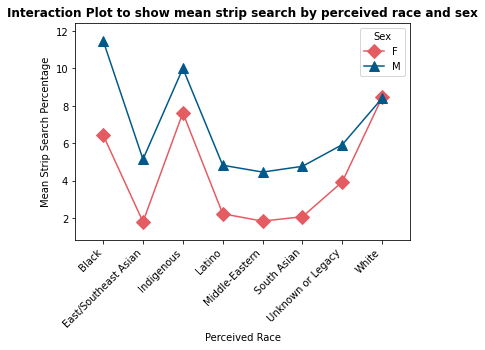

In [ ]:
# set the variable type
Sex = df_fin['Sex'].astype("category")
StrSearpe = df_fin['StripSearchPercentage'].values

# interaction plot
rq_2_interaction = interaction_plot(df_fin['Perceived_Race'], Sex, StrSearpe, 
                                    colors=['#e45c62','#005988'], markers=['D','^'], ms=10)


# set the label 
plt.title('Interaction Plot to show mean strip search by perceived race and sex', fontweight='bold')
plt.ylabel('Mean Strip Search Percentage')
plt.xlabel('Perceived Race')
plt.xticks(rotation=45, ha='right')
plt.show()

## Post-hoc test

In [ ]:
# tukey comparison for Perceived_Race
mcr = mc.MultiComparison(df_fin['StripSearchPercentage'], df_fin['Perceived_Race'])
mcrresult = mcr.tukeyhsd(0.05)
print(mcrresult.summary())

# no need to run Tukey HSD for sex, because sex only has two levels and its signicifancy is proved by ANOVA result already.

              Multiple Comparison of Means - Tukey HSD, FWER=0.05               
       group1               group2        meandiff p-adj   lower   upper  reject
--------------------------------------------------------------------------------
               Black East/Southeast Asian  -6.0568  0.001 -7.6231 -4.4906   True
               Black           Indigenous  -1.4717 0.8555 -4.7084   1.765  False
               Black               Latino  -6.1311  0.001 -8.5565 -3.7056   True
               Black       Middle-Eastern   -6.422  0.001 -8.2867 -4.5573   True
               Black          South Asian   -6.209  0.001  -7.942  -4.476   True
               Black    Unknown or Legacy  -5.0013  0.001 -6.5695 -3.4331   True
               Black                White  -2.1154  0.001 -3.0909 -1.1399   True
East/Southeast Asian           Indigenous   4.5852 0.0014  1.1496  8.0207   True
East/Southeast Asian               Latino  -0.0742    0.9 -2.7593  2.6108  False
East/Southeast Asian       M

In [ ]:
# tukey comparison for the combination of race and sex
interaction_groups =  df_fin.Perceived_Race + " & " +  df_fin.Sex

comp = mc.MultiComparison(df_fin["StripSearchPercentage"], interaction_groups)
post_hoc_res = comp.tukeyhsd()
print(post_hoc_res.summary())
# true: reject the null hypothesis, there is significant difference in mean strip searches between
# black female and black male.
# false: fail to reject, there is no significant difference in mean strip searches between
# effect of black female and East/Southeast Asian male.

                   Multiple Comparison of Means - Tukey HSD, FWER=0.05                   
         group1                   group2          meandiff p-adj   lower    upper  reject
-----------------------------------------------------------------------------------------
               Black & F                Black & M   5.0445  0.001   2.8743  7.2146   True
               Black & F East/Southeast Asian & F  -4.6361  0.007    -8.63 -0.6422   True
               Black & F East/Southeast Asian & M  -1.2958    0.9  -3.9097  1.3182  False
               Black & F           Indigenous & F    1.191    0.9  -4.7956  7.1776  False
               Black & F           Indigenous & M   3.5615 0.5051  -1.4096  8.5327  False
               Black & F               Latino & F  -4.2056 0.7128 -10.9584  2.5471  False
               Black & F               Latino & M  -1.6128    0.9  -5.0658  1.8402  False
               Black & F       Middle-Eastern & F  -4.5972 0.2758 -10.2454  1.0511  False
          

# Research Question #2

##Data Cleaning

In [ ]:
# extract the columns
data_extracted = arr.loc[:,["PersonID","StripSearch", "Age_group__at_arrest_"]]

# Group the data by PersonID and Age
# Calculate the total number of total arrest for each person
data_grouped = data_extracted.groupby(["PersonID","Age_group__at_arrest_"], as_index=False).count()
data_grouped = data_grouped.rename(columns={'StripSearch': 'Total Arrest',"Age_group__at_arrest_": 'Age'})

data_grouped.head(20)

,PersonID,Age,Total Arrest
0,300000,Aged 35 to 44 years,1
1,300001,Aged 17 years and younger,1
2,300002,Aged 35 to 44 years,1
3,300003,Aged 25 to 34 years,6
4,300003,Aged 35 to 44 years,2
5,300004,Aged 25 to 34 years,1
6,300005,Aged 45 to 54 years,1
7,300006,Aged 55 to 64 years,2
8,300007,Aged 25 to 34 years,8
9,300008,Aged 25 to 34 years,1


In [ ]:
# Duplicate the strip search column to calculate the average later.
data_extracted['StripSearchPercentage'] = data_extracted.loc[:, 'StripSearch']
data_extracted = data_extracted.rename(columns={"Age_group__at_arrest_": 'Age'})

# Group the rows by personID.
data_percent = data_extracted.groupby(['PersonID',"Age"], as_index=False).agg({'StripSearch':'sum', 
                                                                               'StripSearchPercentage':'mean'})
# transform the percentage column into % values
data_percent['StripSearchPercentage'] = data_percent['StripSearchPercentage'].multiply(100)

# glimpse the dataset
data_percent.head(20)

,PersonID,Age,StripSearch,StripSearchPercentage
0,300000,Aged 35 to 44 years,0,0.000000
1,300001,Aged 17 years and younger,0,0.000000
2,300002,Aged 35 to 44 years,0,0.000000
3,300003,Aged 25 to 34 years,1,16.666667
4,300003,Aged 35 to 44 years,0,0.000000
5,300004,Aged 25 to 34 years,0,0.000000
6,300005,Aged 45 to 54 years,0,0.000000
7,300006,Aged 55 to 64 years,0,0.000000
8,300007,Aged 25 to 34 years,1,12.500000
9,300008,Aged 25 to 34 years,0,0.000000


In [ ]:
# Since some observations have more than one age group, to avoid misleading info, these duplicated obs are deleted.
# Get duplicate rows with the same person ID
data_dup = data_percent[data_percent.duplicated('PersonID')]

# get the list of Person ID that have more than one observation.
dup = data_dup['PersonID'].unique()

# remove the duplicate rows
data_dup_reomoved = data_percent[~(data_percent['PersonID'].isin(dup))]

# replace age group names
data_dup_reomoved = data_dup_reomoved.replace(['Aged 17 years and under'],'Aged 17 years and younger')
data_dup_reomoved = data_dup_reomoved.replace(['Aged 65 and older'], 'Aged 65 years and older')
data_dup_reomoved.head(20)

,PersonID,Age,StripSearch,StripSearchPercentage
0,300000,Aged 35 to 44 years,0,0.0
1,300001,Aged 17 years and younger,0,0.0
2,300002,Aged 35 to 44 years,0,0.0
5,300004,Aged 25 to 34 years,0,0.0
6,300005,Aged 45 to 54 years,0,0.0
7,300006,Aged 55 to 64 years,0,0.0
8,300007,Aged 25 to 34 years,1,12.5
9,300008,Aged 25 to 34 years,0,0.0
10,300009,Aged 35 to 44 years,0,0.0
11,300010,Aged 45 to 54 years,0,0.0


In [ ]:
# merge the total arrest column
data_final = pd.merge(data_dup_reomoved, data_grouped, how="left", on=["PersonID", "Age"])

# Rearrage the order of columns
data_final = data_final[['PersonID',
                 'Age',
                 'StripSearch',
                 'Total Arrest',
                 'StripSearchPercentage']]

# Glimpse the dataset
data_final.head(20)

,PersonID,Age,StripSearch,Total Arrest,StripSearchPercentage
0,300000,Aged 35 to 44 years,0,1.0,0.0
1,300001,Aged 17 years and younger,0,1.0,0.0
2,300002,Aged 35 to 44 years,0,1.0,0.0
3,300004,Aged 25 to 34 years,0,1.0,0.0
4,300005,Aged 45 to 54 years,0,1.0,0.0
5,300006,Aged 55 to 64 years,0,2.0,0.0
6,300007,Aged 25 to 34 years,1,8.0,12.5
7,300008,Aged 25 to 34 years,0,1.0,0.0
8,300009,Aged 35 to 44 years,0,1.0,0.0
9,300010,Aged 45 to 54 years,0,1.0,0.0


## EDA

In [ ]:
# Group the rows with same age
gp_age = data_final.groupby(['Age'], as_index=False).agg({'StripSearch':'sum','Total Arrest':'sum'})

# Calculate the percentage of strip search in each group of ageStripSearch
gp_age["StripSearchPercentage"] = gp_age['StripSearch']/gp_age['Total Arrest']*100  

gp_age.head(20)

,Age,StripSearch,Total Arrest,StripSearchPercentage
0,Aged 17 years and younger,167,1212.0,13.778878
1,Aged 18 to 24 years,1161,9261.0,12.536443
2,Aged 25 to 34 years,2490,19641.0,12.677562
3,Aged 35 to 44 years,1934,15134.0,12.779173
4,Aged 45 to 54 years,850,8587.0,9.898684
5,Aged 55 to 64 years,348,4395.0,7.918089
6,Aged 65 years and older,28,562.0,4.982206


In [ ]:
# Seperate the rows into two different age group
group_1 = data_final.replace(['Aged 17 years and younger','Aged 18 to 24 years','Aged 25 to 34 years'],'Aged under 35')
group_2 = data_final.replace(['Aged 35 to 44 years','Aged 45 to 54 years','Aged 55 to 64 years','Aged 65 years and older'],'Aged 35 and above')

age_under_35 = group_1[(group_1['Age'] == 'Aged under 35')]
age_35_and_above = group_2[(group_2['Age'] == 'Aged 35 and above')]

###Descriptive Statistics

In [ ]:
gp_age.describe()

,StripSearch,Total Arrest,StripSearchPercentage
count,7.000000,7.000000,7.000000
mean,996.857143,8398.857143,10.653005
std,931.359656,7090.189594,3.218296
min,28.000000,562.000000,4.982206
25%,257.500000,2803.500000,8.908386
50%,850.000000,8587.000000,12.536443
75%,1547.500000,12197.500000,12.728367
max,2490.000000,19641.000000,13.778878


In [ ]:
data_final.groupby(['Age'])['StripSearchPercentage'].describe()

,count,mean,std,min,25%,50%,75%,max
Age,,,,,,,,
Aged 17 years and younger,1789.0,5.784335,21.919650,0.0,0.0,0.0,0.0,100.0
Aged 18 to 24 years,6204.0,10.129994,27.713831,0.0,0.0,0.0,0.0,100.0
Aged 25 to 34 years,11065.0,8.925399,25.140877,0.0,0.0,0.0,0.0,100.0
Aged 35 to 44 years,8152.0,8.375334,23.736874,0.0,0.0,0.0,0.0,100.0
Aged 45 to 54 years,5107.0,6.941933,22.348021,0.0,0.0,0.0,0.0,100.0
Aged 55 to 64 years,2934.0,5.512233,20.499104,0.0,0.0,0.0,0.0,100.0
Aged 65 years and older,987.0,2.549814,15.382387,0.0,0.0,0.0,0.0,100.0


In [ ]:
# Boxplot for youth category at arrest
# Box for youth
fig = go.Figure()
fig.add_trace(go.Box(
    y= you["StripSearchPercentage"], 
    name = 'Youth',
    marker_color = '#bc5090',
    boxmean=True))

# Box for not a youth
fig.add_trace(go.Box(
    y= ntyou["StripSearchPercentage"], 
    name = 'Not a youth',
    marker_color = '#58508d',
    boxmean=True))

fig.update_layout(title={'text': '<b>Comparison of Percentage of Strip Searches in youth category at arrest</b>',
                         'y': 0.89},
                  yaxis_title = "Percentage of Strip Searches",
                  xaxis_title = "Youth category",
                  width=800, height=500)

fig.show()

In [ ]:
# Bar plot for count total arrest for different age groups
barplot = px.bar(gp_age, x='Age', y = 'Total Arrest',
             title = 'Total arrest for different age groups',
             color_discrete_sequence= ['#3d708f'],
             width=700, height=600)

# Show plot
barplot.show()

In [ ]:
# Bar plot for count total arrest for different age groups
barplot = px.bar(gp_age, x='Age', y = 'StripSearchPercentage',
             title = 'Strip Search Percentage for different age groups',
             color_discrete_sequence= ['#8cbcac'],
             width=800, height=600)

barplot.update_layout(title={'text': '<b>Strip Search Percentage for different age groups</b>'},
                      yaxis_title = "Percentage of Strip Searches")
barplot.update_traces(width=0.6)

# Show plot
barplot.show()

In [ ]:
# create box plot for age groups
boxplot = go.Figure()
boxplot.add_trace(go.Box(
    x = data_final["Age"], y= data_final["StripSearchPercentage"],
    boxmean=True))

boxplot.update_layout(title={'text': '<b>Comparison of Percentage of Strip Searches for different age groups</b>'},
                  yaxis_title = "Percentage of Strip Searches",
                  xaxis_title = "Age",
                  width=900, height=500)

###Assumption Check:

####Normality Check

In [ ]:
print(stats.shapiro(age_under_35['StripSearchPercentage']))
print(stats.shapiro(age_35_and_above['StripSearchPercentage']))

ShapiroResult(statistic=0.3869403600692749, pvalue=0.0)
ShapiroResult(statistic=0.3521570563316345, pvalue=0.0)


/usr/local/lib/python3.8/dist-packages/scipy/stats/morestats.py:1760: UserWarning:

p-value may not be accurate for N > 5000.



###Welch's t-test

In [ ]:
# Welch's t-test for Age
stats.ttest_ind(age_under_35['StripSearchPercentage'], age_35_and_above['StripSearchPercentage'], equal_var = False)

Ttest_indResult(statistic=7.4919359859007235, pvalue=6.940980032529335e-14)

In [ ]:
# Calculate mean and standard deviation of Age 
# Age under 35 shows higher mean strip search percentage
print('Mean Strip Search Percentage for age under 35 and 35 and above are:', age_under_35['StripSearchPercentage'].mean(), age_35_and_above['StripSearchPercentage'].mean())
print('Standard deviation for age under 35 and 35 and above are:',age_under_35['StripSearchPercentage'].std(), age_35_and_above['StripSearchPercentage'].std())

Mean Strip Search Percentage for age under 35 and 35 and above are: 9.022677619677653 7.12559541359529
Standard deviation for age under 35 and 35 and above are: 25.757110500735248 22.43890203821706


In [ ]:
# compute Confidence interval
cm_2 = sms.CompareMeans(sms.DescrStatsW(age_under_35['StripSearchPercentage']), sms.DescrStatsW(age_35_and_above['StripSearchPercentage']))
print('Confidence interval for Strip Search Percentage:',cm.tconfint_diff(usevar='unequal'))

Confidence interval for Strip Search Percentage: (7.815482974282132, 9.820009378547576)


## One-way ANOVA

In [ ]:
# Perform One-way ANOVA using spicy.stats
sample_1 = data_final[data_final['Age'] == 'Aged 17 years and younger']['StripSearchPercentage']
sample_2 = data_final[data_final['Age'] == 'Aged 18 to 24 years']['StripSearchPercentage']
sample_3 = data_final[data_final['Age'] == 'Aged 25 to 34 years']['StripSearchPercentage']
sample_4 = data_final[data_final['Age'] == 'Aged 35 to 44 years']['StripSearchPercentage']
sample_5 = data_final[data_final['Age'] == 'Aged 45 to 54 years']['StripSearchPercentage']
sample_6 = data_final[data_final['Age'] == 'Aged 55 to 64 years']['StripSearchPercentage']
sample_7 = data_final[data_final['Age'] == 'Aged 65 years and older']['StripSearchPercentage']

statistic, pvalue = stats.f_oneway(sample_1, sample_2, sample_3,sample_4,sample_5,sample_6,sample_7)

print(f'One-way ANOVA: s = {statistic}, p = {pvalue}')

One-way ANOVA: s = 28.50590773248095, p = 3.286484748171146e-34


In [ ]:
# Perform One-way ANOVA using statsmodels
model_2 = ols('StripSearchPercentage ~ C(Age)', data=data_final).fit()
aov_table = sm.stats.anova_lm(model_2, typ=2)
aov_table

,sum_sq,df,F,PR(>F)
C(Age),1.001966e+05,6.0,28.505908,3.286485e-34
Residual,2.122498e+07,36231.0,NaN,NaN


### Assumption check

In [ ]:
# Normality check
stats.shapiro(model_2.resid)

/usr/local/lib/python3.8/dist-packages/scipy/stats/morestats.py:1760: UserWarning:

p-value may not be accurate for N > 5000.



ShapiroResult(statistic=0.42542874813079834, pvalue=0.0)

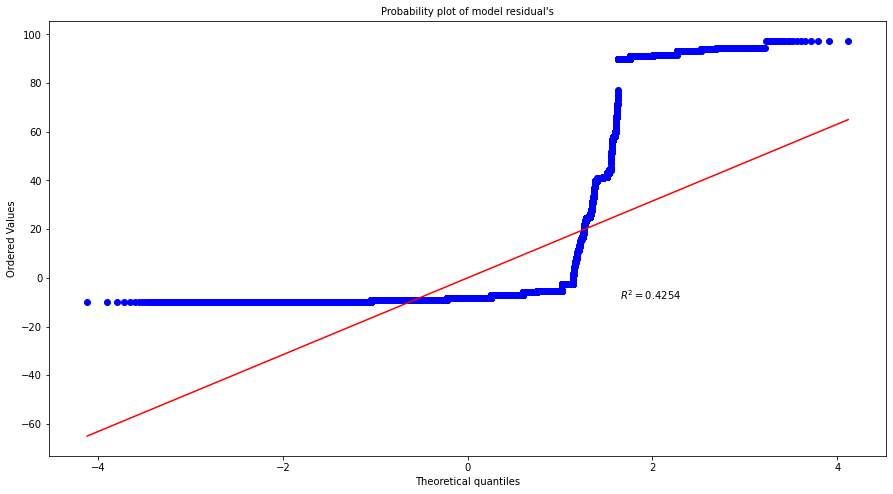

In [ ]:
# Visual check of normality
fig = plt.figure(figsize= (15, 8))
ax = fig.add_subplot(111)

normality_plot, stat = stats.probplot(model_2.resid, plot= plt, rvalue= True)
ax.set_title("Probability plot of model residual's", fontsize= 10)
ax.set

plt.show()

In [ ]:
# Homogeneity of variance
df_1 = data_final[data_final['Age'] == 'Aged 17 years and younger']
df_2 = data_final[data_final['Age'] == 'Aged 18 to 24 years']
df_3 = data_final[data_final['Age'] == 'Aged 25 to 34 years']
df_4 = data_final[data_final['Age'] == 'Aged 35 to 44 years']
df_5 = data_final[data_final['Age'] == 'Aged 45 to 54 years']
df_6 = data_final[data_final['Age'] == 'Aged 55 to 64 years']
df_7 = data_final[data_final['Age'] == 'Aged 65 years and older']

stats.levene(df_1['StripSearchPercentage'],df_2['StripSearchPercentage'],df_3['StripSearchPercentage'],
             df_4['StripSearchPercentage'],df_5['StripSearchPercentage'],df_6['StripSearchPercentage'],
             df_7['StripSearchPercentage'],center = 'mean')

LeveneResult(statistic=110.93749769197845, pvalue=3.18623837719274e-139)

### Post-hoc test

In [ ]:
# Post-hoc testing using hukey hsd
comp = mc.MultiComparison(data_final['StripSearchPercentage'], data_final['Age'])
post_hoc_res = comp.tukeyhsd()
post_hoc_res.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
Aged 17 years and younger,Aged 18 to 24 years,4.3457,0.001,2.4306,6.2608,True
Aged 17 years and younger,Aged 25 to 34 years,3.1411,0.001,1.3226,4.9596,True
Aged 17 years and younger,Aged 35 to 44 years,2.591,0.001,0.7278,4.4542,True
Aged 17 years and younger,Aged 45 to 54 years,1.1576,0.5759,-0.803,3.1182,False
Aged 17 years and younger,Aged 55 to 64 years,-0.2721,0.9,-2.4128,1.8686,False
Aged 17 years and younger,Aged 65 years and older,-3.2345,0.0133,-6.0641,-0.4049,True
Aged 18 to 24 years,Aged 25 to 34 years,-1.2046,0.0283,-2.3365,-0.0727,True
Aged 18 to 24 years,Aged 35 to 44 years,-1.7547,0.001,-2.957,-0.5523,True
Aged 18 to 24 years,Aged 45 to 54 years,-3.1881,0.001,-4.5364,-1.8397,True
Aged 18 to 24 years,Aged 55 to 64 years,-4.6178,0.001,-6.2167,-3.0188,True
